<a href="https://colab.research.google.com/github/imjunyoung404/ai-class-3-2/blob/main/5%EC%A3%BC%EC%B0%A8/2nd%20AE%20%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [10]:
# 데이터셋 로드
data = pd.read_csv('/content/creditcard.csv')

In [11]:
# 정상 (0) 및 비정상 (1) 클래스만 남김
data = data[(data['Class'] == 0) | (data['Class'] == 1)]

In [12]:
# 특징(입력 데이터)과 라벨(정상/비정상)을 분리
X = data.drop(['Class', 'Time'], axis=1)
y = data['Class']

In [13]:
# 학습 데이터와 테스트 데이터로 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
# 학습 데이터를 학습/검증 데이터로 다시 나눔
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [15]:
# 학습/검증 데이터에서 정상 (0) 데이터만 남김
X_train = X_train[y_train == 0]
X_valid = X_valid[y_valid == 0]


In [16]:
# 데이터를 정규화 (Amount 열 등 수치의 차이가 크므로)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [17]:
# 오토인코더 모델 생성
input_dim = X_train_scaled.shape[1]
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

In [18]:
# 모델 컴파일 (최적화 함수와 손실 함수 설정)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [19]:
# 오토인코더 학습 (정상 데이터만 학습에 사용)
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_valid_scaled, X_valid_scaled))

Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1000 - val_loss: 0.9712
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9042 - val_loss: 0.9208
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8647 - val_loss: 0.9083
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8473 - val_loss: 0.9029
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8440 - val_loss: 0.8973
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8356 - val_loss: 0.8941
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8412 - val_loss: 0.8912
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8345 - val_loss: 0.8871
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8207 - val_loss: 0.8833
Epoch 10/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8197 - val_loss: 0.8778
Epoch 11/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8316 - val_loss: 0.8738
Epoch 12/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [20]:
# 테스트 데이터의 재구성 오류 계산 (정상/비정상 포함)
predictions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [21]:
# 정상 데이터의 재구성 오류 기반 임계값 설정
threshold = np.percentile(mse[y_test == 0], 95)

In [22]:
# 재구성 오류를 기준으로 분류 (임계값 초과 시 비정상으로 분류)
y_pred = [1 if e > threshold else 0 for e in mse]

In [23]:
# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

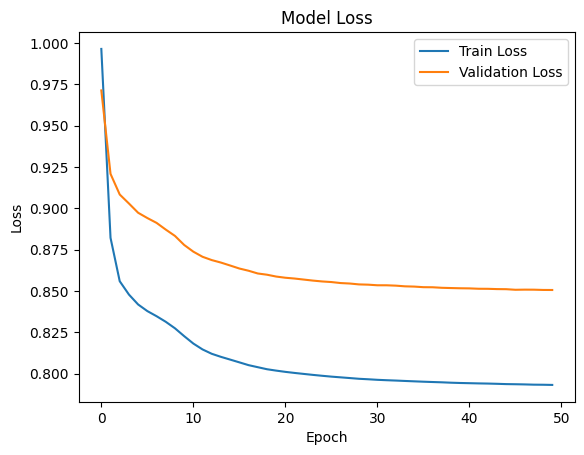

In [24]:
# 학습 손실 그래프 그리기
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [25]:
print('Accuracy:', accuracy)
print('Classification Report:', classification_rep)

Accuracy: 0.9498613110494716
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.88      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.91      0.52     56962
weighted avg       1.00      0.95      0.97     56962

